<a href="https://colab.research.google.com/github/malhotrakavyansh/MLforGDSC/blob/main/.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

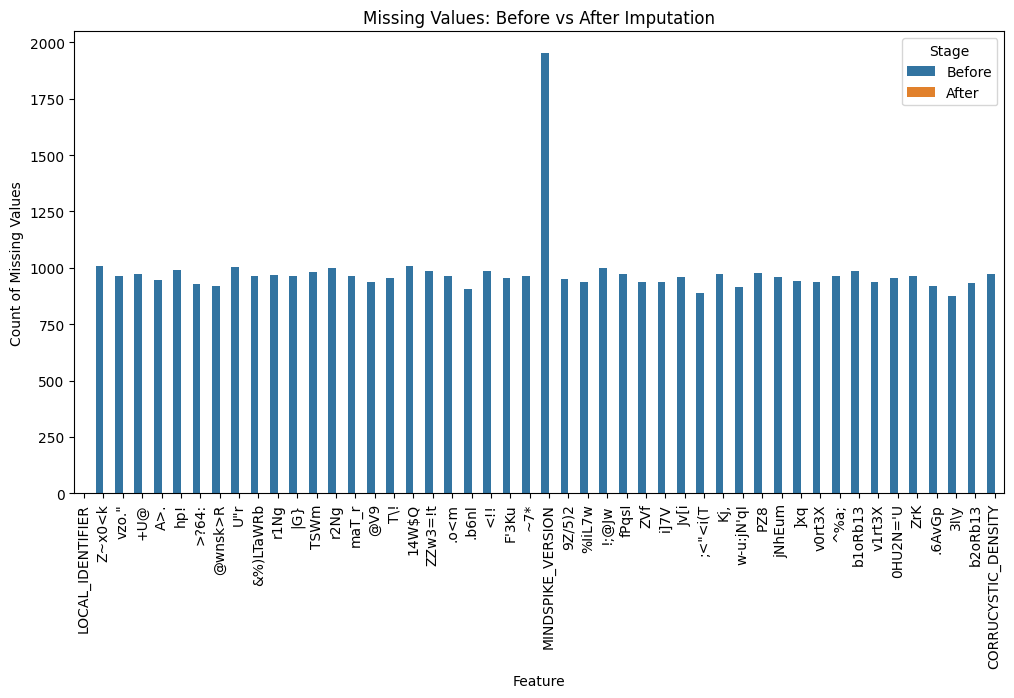

Data shapes:
X_train: (9600, 68)
y_train: (9600,)
X_val: (2400, 68)
y_val: (2400,)

Target variable info:
y_train dtype: float64
y_train has NaN: 0
y_train has inf: 0
y_train range: [-29.6876, 920.2305]

Feature info:
X_train has NaN: 0
X_train has inf: 0
All column names look clean
Using CPU with basic configuration
❌ Basic model failed: got an unexpected keyword argument 'squared'
 Still failing: got an unexpected keyword argument 'squared'
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=200; total time=   0.7s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=200; total time=   0.7s
[CV] END ..learning_rate=0.05, max_depth=3, n_estimators=200; total time=   0.7s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time=   0.7s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time=   0.7s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=200; total time=   0.7s
[CV] EN

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import re
import matplotlib.pyplot as plt
import seaborn as sns


train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")


for col in train.columns:
    if train[col].isnull().sum() > 0:
        if train[col].dtype in ['int64', 'float64']:
            train[col] = train[col].fillna(train[col].median())
        else:
            train[col] = train[col].fillna(train[col].mode()[0])

for col in test.columns:
    if test[col].isnull().sum() > 0:
        if test[col].dtype in ['int64', 'float64']:
            test[col] = test[col].fillna(test[col].median())
        else:
            test[col] = test[col].fillna(test[col].mode()[0])

train_raw = pd.read_csv("train.csv")
missing_before = train_raw.isnull().sum()
missing_after = train.isnull().sum()

missing_df = pd.DataFrame({
    "Feature": missing_before.index,
    "Before": missing_before.values,
    "After": missing_after.values
})

missing_df = missing_df.melt(id_vars="Feature", var_name="Stage", value_name="Missing Count")

plt.figure(figsize=(12,6))
sns.barplot(data=missing_df, x="Feature", y="Missing Count", hue="Stage")
plt.xticks(rotation=90)
plt.title("Missing Values: Before vs After Imputation")
plt.ylabel("Count of Missing Values")
plt.show()




X = train.drop("CORRUCYSTIC_DENSITY", axis=1)
y = train["CORRUCYSTIC_DENSITY"]

X = pd.get_dummies(X, drop_first=True)
test = pd.get_dummies(test, drop_first=True)


X, test = X.align(test, join="left", axis=1, fill_value=0)


def clean_feature_names(columns):
    """Clean column names to be XGBoost compatible"""
    cleaned = []
    for col in columns:

        clean_name = str(col)

        clean_name = re.sub(r'[<>\[\],]', '_', clean_name)

        clean_name = re.sub(r'[^a-zA-Z0-9_]', '_', clean_name)

        clean_name = re.sub(r'_+', '_', clean_name)

        clean_name = clean_name.strip('_')

        if not clean_name:
            clean_name = f'feature_{len(cleaned)}'
        cleaned.append(clean_name)
    return cleaned

X.columns = clean_feature_names(X.columns)
test.columns = clean_feature_names(test.columns)


X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)


print("Data shapes:")
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"y_val: {y_val.shape}")

print("\nTarget variable info:")
print(f"y_train dtype: {y_train.dtype}")
print(f"y_train has NaN: {y_train.isnull().sum()}")
print(f"y_train has inf: {np.isinf(y_train).sum()}")
print(f"y_train range: [{y_train.min():.4f}, {y_train.max():.4f}]")

print("\nFeature info:")
print(f"X_train has NaN: {X_train.isnull().sum().sum()}")
print(f"X_train has inf: {np.isinf(X_train).sum().sum()}")



problematic_cols = []
for col in X_train.columns:
    if any(char in str(col) for char in ['[', ']', '<', '>', ',']):
        problematic_cols.append(col)
if problematic_cols:
    print(f"Found problematic columns: {problematic_cols}")
else:
    print("All column names look clean")


xgb = XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    n_jobs=1,
    tree_method="hist",
    enable_categorical=False
)
print("Using CPU with basic configuration")



try:
    test_model = XGBRegressor(
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1,
        random_state=42,
        tree_method="hist"
    )
    test_model.fit(X_train, y_train)
    test_pred = test_model.predict(X_val)
    test_rmse = mean_squared_error(y_val, test_pred, squared=False)
    print(f"✅ Basic model works! RMSE: {test_rmse:.4f}")
except Exception as e:
    print(f"❌ Basic model failed: {e}")



    X_train = X_train.replace([np.inf, -np.inf], np.nan)
    X_train = X_train.fillna(X_train.median())
    X_val = X_val.replace([np.inf, -np.inf], np.nan)
    X_val = X_val.fillna(X_train.median())

    y_train = y_train.replace([np.inf, -np.inf], np.nan)
    if y_train.isnull().sum() > 0:
        y_train = y_train.fillna(y_train.median())


    try:
        test_model.fit(X_train, y_train)
        test_pred = test_model.predict(X_val)
        test_rmse = mean_squared_error(y_val, test_pred, squared=False)
        print(f" Fixed model works! RMSE: {test_rmse:.4f}")
    except Exception as e2:
        print(f" Still failing: {e2}")


param_dist = {
    "n_estimators": [100, 200],
    "max_depth": [3, 6],
    "learning_rate": [0.05, 0.1]
}

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=4,
    scoring="neg_root_mean_squared_error",
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=1,
    error_score='raise'
)


random_search.fit(X_train, y_train)

print("Best Params:", random_search.best_params_)
print("Best CV Score (RMSE):", -random_search.best_score_)


best_model = random_search.best_estimator_
y_pred = best_model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print("Validation RMSE:", rmse)


test_preds = best_model.predict(test)


if "LOCAL_IDENTIFIER" in test.columns:
    submission_id = test["LOCAL_IDENTIFIER"]
else:

    print("Warning: LOCAL_IDENTIFIER not found in test data. Creating sequential IDs.")
    submission_id = range(len(test))

submission = pd.DataFrame({
    "ID": submission_id,
    "CORRUCYSTIC_DENSITY": test_preds
})

submission.to_csv("submission.csv", index=False)
print(" Submission file saved as submission.csv")